In [5]:
from keras import backend as K

ModuleNotFoundError: No module named 'keras'

In [7]:
import numpy as np
import pandas as pd

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

ModuleNotFoundError: No module named 'keras'

# Random Example

In [9]:
model = Sequential([
    Dense(100, input_shape=(2,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

train_data = np.array([
    [1, 1],
    [1, 0],
    [0, 1],
    [0, 0]
])

# X AND Y
train_labels = keras.utils.to_categorical(np.array([
    1,
    0,
    0,
    1
]), num_classes=2)

model.summary()


NameError: name 'Sequential' is not defined

In [10]:
model.fit(train_data, train_labels, epochs=10, verbose=False)
model.evaluate(train_data, train_labels)

NameError: name 'model' is not defined

In [11]:
model.predict(train_data)

NameError: name 'model' is not defined

# Softmax Regression

## Try to Achieve This
`X and (Y OR Z)`

In [12]:
model = Sequential([
    Dense(500, input_shape=(3,), activation='sigmoid'),
    Dense(2, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [13]:
train_data = np.array([
    [1, 1, 1],
    [1, 1, 0],
    [1, 0, 1],
    [1, 0, 0],
    [0, 1, 1],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 0],
])

# X AND Y
train_labels = keras.utils.to_categorical(np.array([
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0
]), num_classes=2)

NameError: name 'keras' is not defined

In [14]:
model.fit(train_data, train_labels, epochs=100, verbose=True)

NameError: name 'model' is not defined

# Indodax Data Retrieval

In [15]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [16]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = 15
time_begin = int(datetime.datetime(2019, 3, 17).timestamp())
time_end = int(datetime.datetime.now().timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)

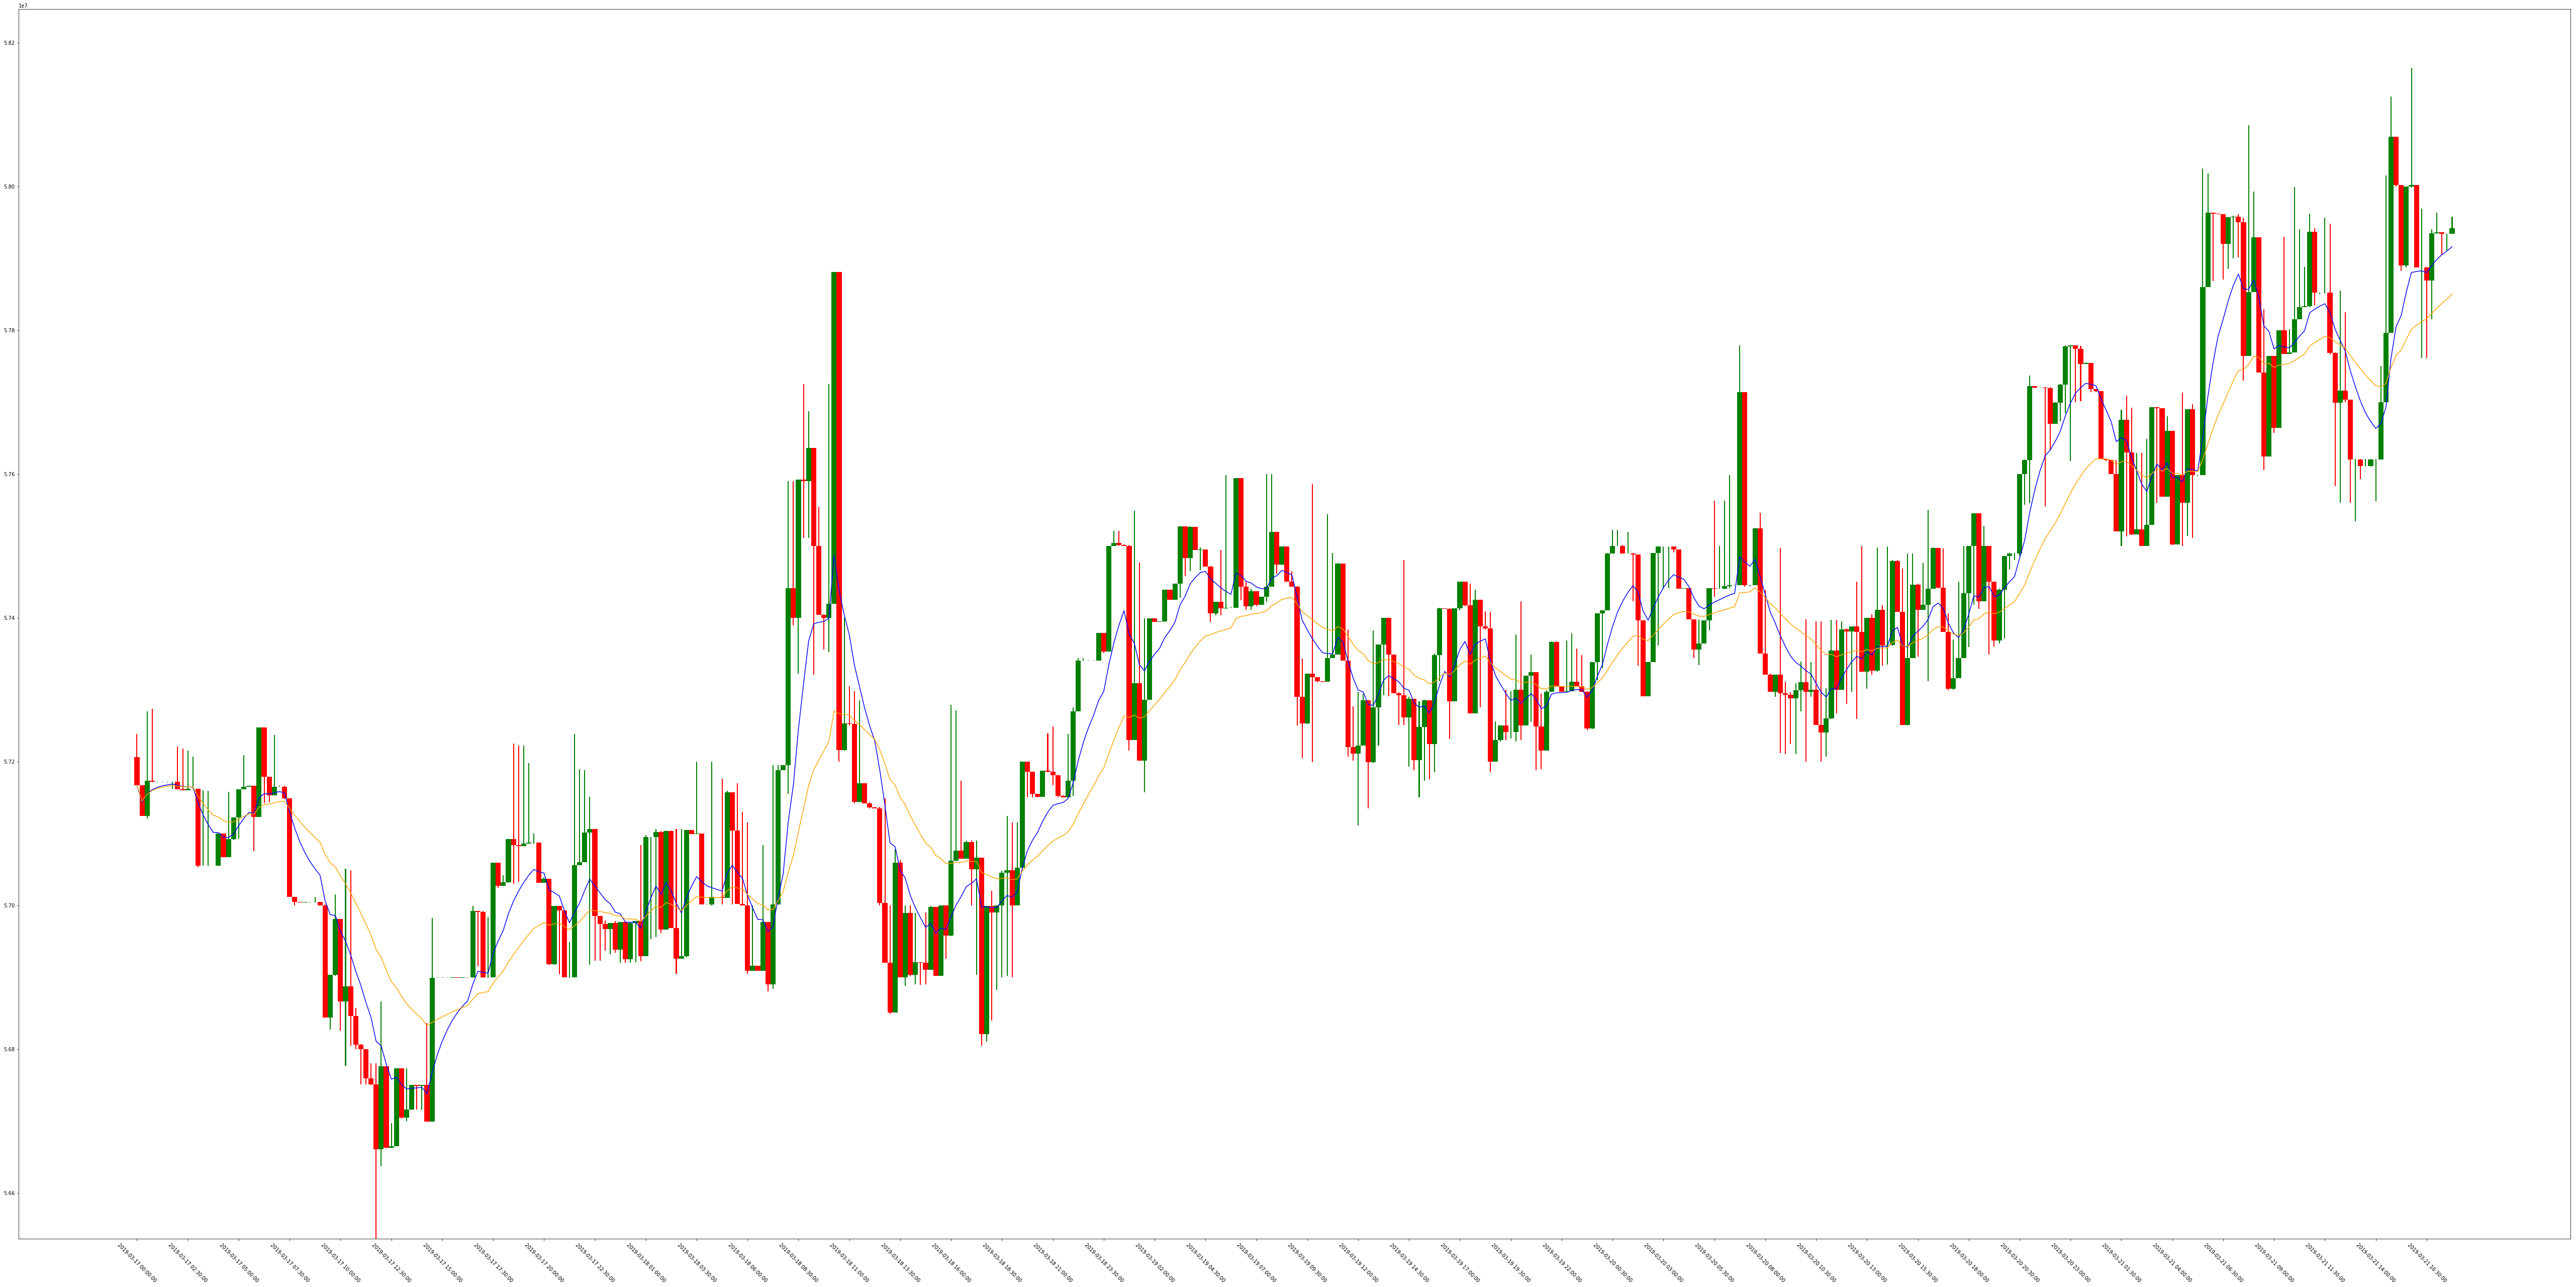

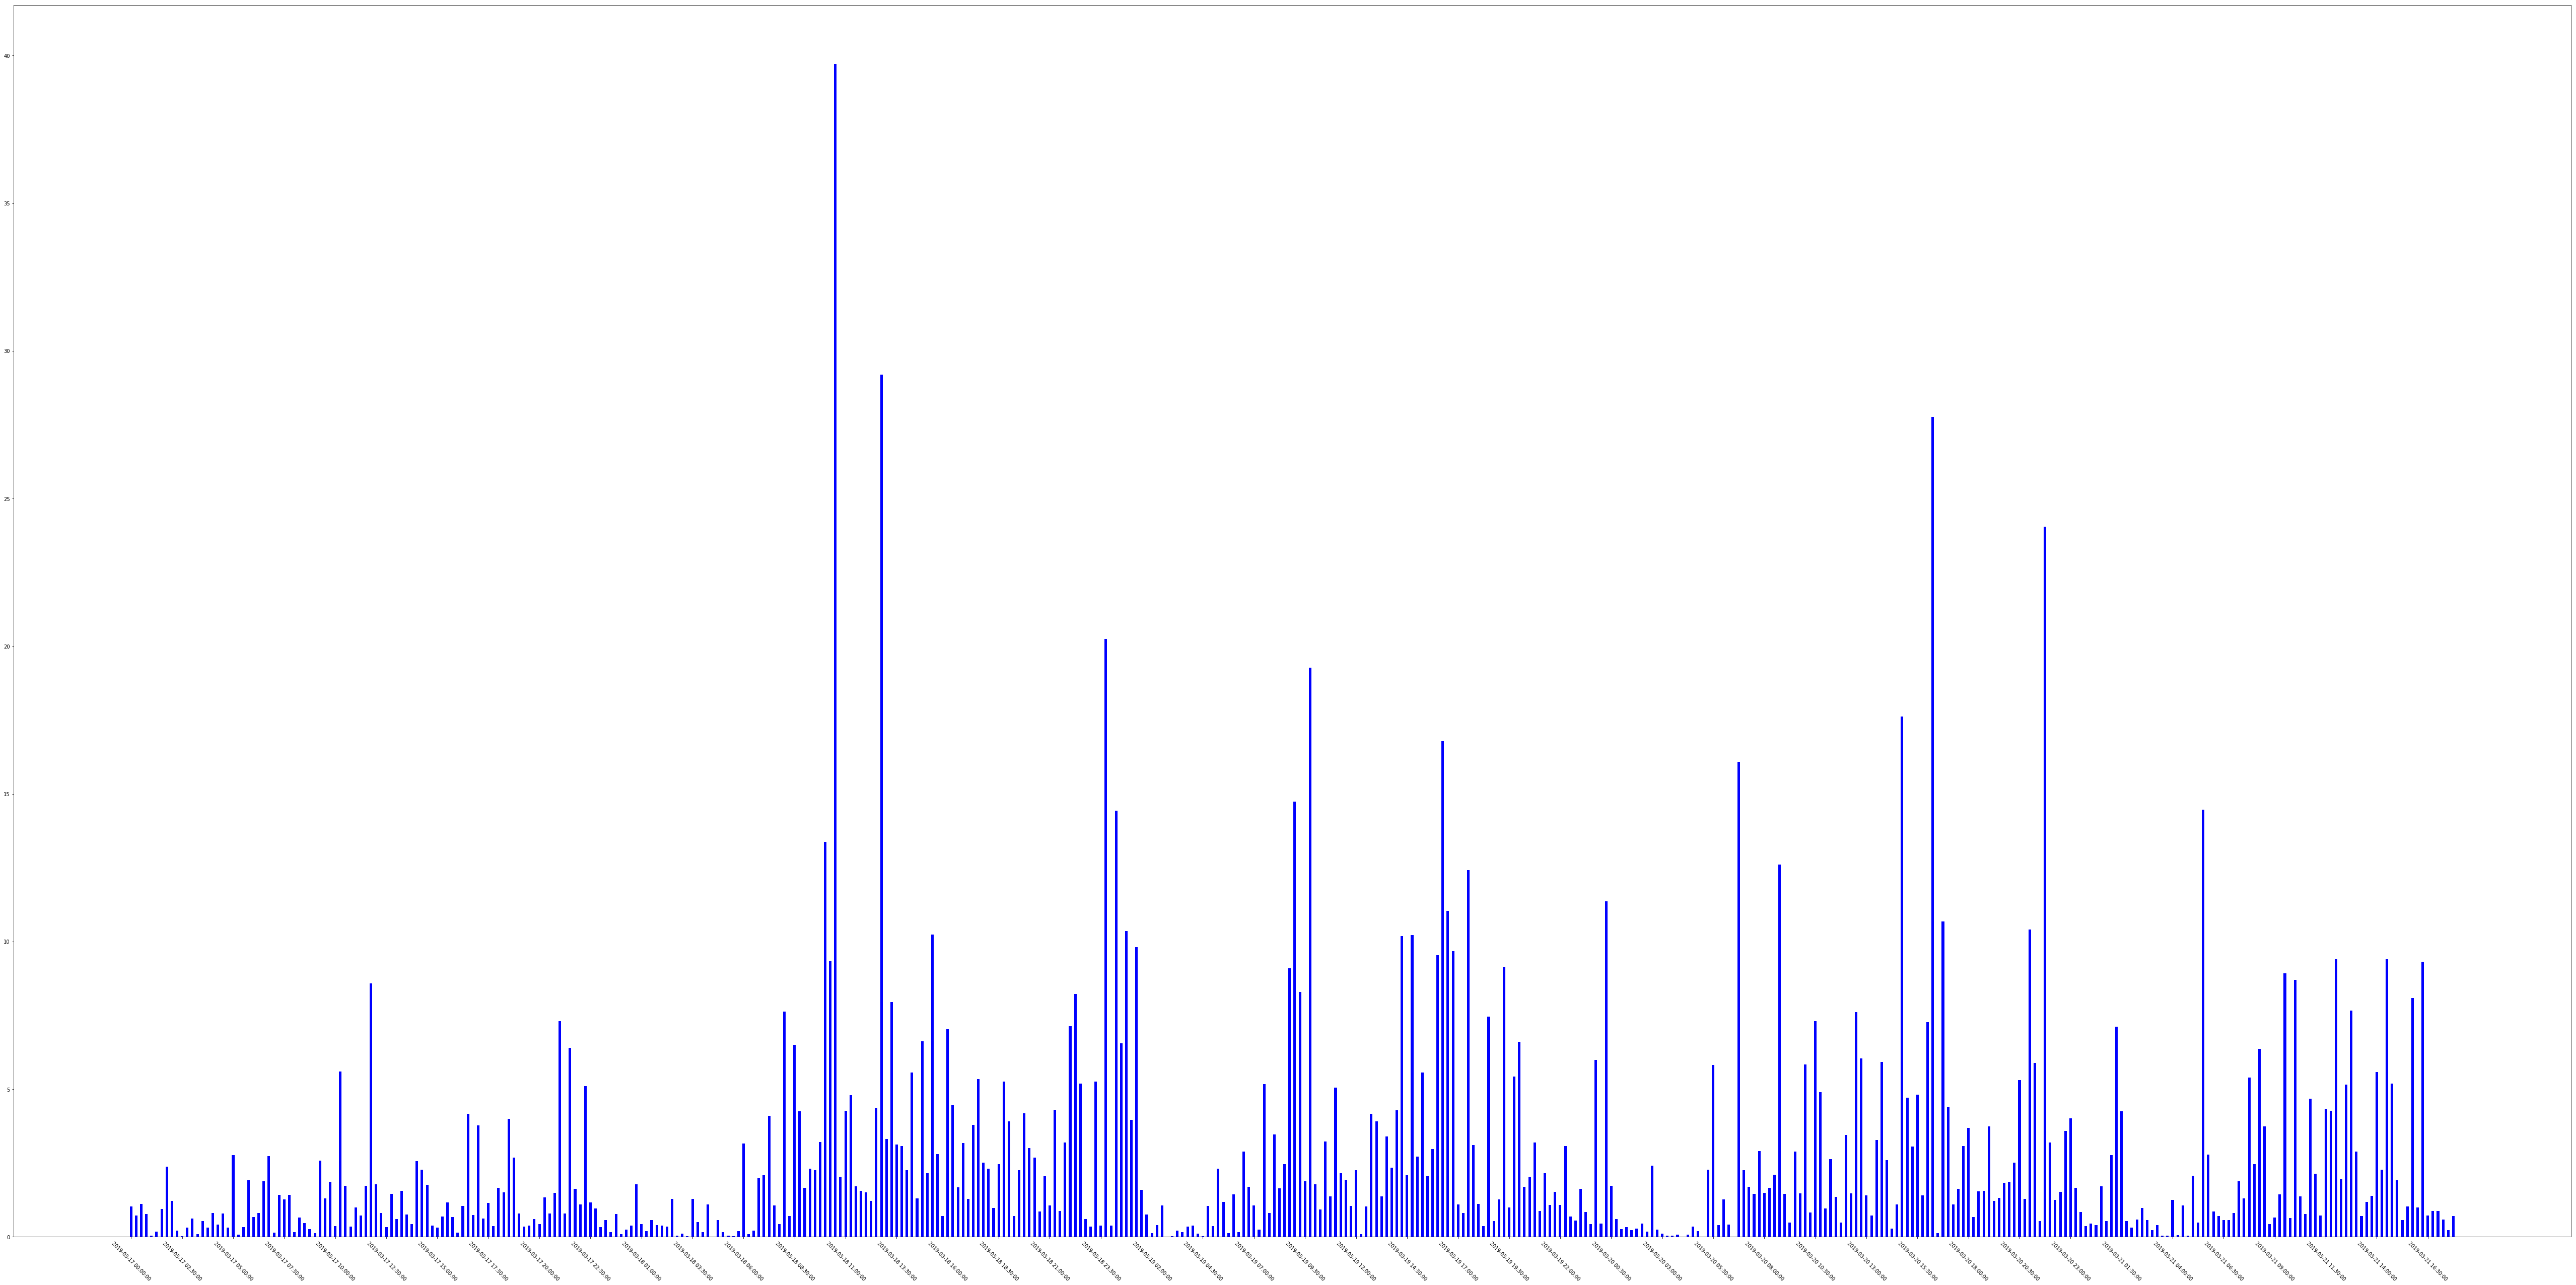

In [17]:
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
candle_color = lambda o, c: 'g' if c >= o else 'r'
fig_w = len(price.open)//5
fig_h = fig_w // 2
plt.figure(figsize=(fig_w, fig_h))
plt.bar( [i for i in range(len(price.open))],
        [abs(c-o) for c,o in zip(price.close, price.open)],
        [1 for i in range(len(price.open))],
        [min(c, o) for c,o in zip(price.close, price.open)],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.bar( [i for i in range(len(price.high))],
        [h-l for h,l in zip(price.high, price.low)],
        [.2 for i in range(len(price.high))],
        [l for l in price.low],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=10).mean(), color='blue')
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=30).mean(), color='orange')
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.figure(figsize=(fig_w, fig_h))
plt.bar([i for i in range(len(price.volume))],
        price.volume,
        .5,
        color='blue'
)
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.show()

In [33]:
price

,open,close,high,low,volume
2019-03-17 00:00:00,57206000,57167000,57238000,57167000,1.020837
2019-03-17 00:15:00,57167000,57124000,57167000,57124000,0.724568
2019-03-17 00:30:00,57124000,57173000,57270000,57121000,1.121520
2019-03-17 00:45:00,57173000,57172000,57273000,57171000,0.764381
2019-03-17 01:00:00,57172000,57172000,57172000,57171000,0.038674
2019-03-17 01:15:00,57172000,57172000,57172000,57171000,0.172792
2019-03-17 01:30:00,57172000,57172000,57172000,57171000,0.943764
2019-03-17 01:45:00,57172000,57172000,57172000,57162000,2.374741
2019-03-17 02:00:00,57172000,57161000,57221000,57161000,1.217957
2019-03-17 02:15:00,57161000,57160000,57218000,57160000,0.207871


In [270]:
action_list = {}
action_list['\\'] = {'action'}
action_list['action'] = []

# weird workaround due to limitation to column name, see below
# HOLD --> 0
# BUY --> -1
# SELL --> 1
for i in range(len(price.index)-1):
    current = price.iloc[i]
    before = price.iloc[i-1]
    after = price.iloc[i+1]
    if current.close < after.close:
        if current.close > before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(-1)
    elif current.close > after.close:
        if current.close < before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(1)
    else:
        action_list['action'].append(0)
action_list['action'].append(0)
action_frame = pd.DataFrame(action_list['action']).set_index(price.index)

# we need the stock price somehow
action_frame = action_frame.join(price)

# column names change 'Action' to 'low'
# weird workaround due to limitation to column name
# reference : https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed.html?highlight=pandasdata
action_frame.columns = ['low', 'open', 'close', 'high', 'real_low', 'volume']

In [271]:
action_frame

,low,open,close,high,real_low,volume
2019-03-17 00:00:00,0,57206000,57167000,57238000,57167000,1.020837
2019-03-17 00:15:00,-1,57167000,57124000,57167000,57124000,0.724568
2019-03-17 00:30:00,1,57124000,57173000,57270000,57121000,1.121520
2019-03-17 00:45:00,0,57173000,57172000,57273000,57171000,0.764381
2019-03-17 01:00:00,0,57172000,57172000,57172000,57171000,0.038674
2019-03-17 01:15:00,0,57172000,57172000,57172000,57171000,0.172792
2019-03-17 01:30:00,0,57172000,57172000,57172000,57171000,0.943764
2019-03-17 01:45:00,1,57172000,57172000,57172000,57162000,2.374741
2019-03-17 02:00:00,0,57172000,57161000,57221000,57161000,1.217957
2019-03-17 02:15:00,-1,57161000,57160000,57218000,57160000,0.207871


In [272]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [273]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [274]:
# data_feed = btfeeds.PandasData(dataname=price, openinterest=None)
data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)
#print(data_feed)

In [275]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(10000000000.0)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 10000000000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57124000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57173000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57160000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57162000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57055000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57100000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57067000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57166000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57123000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57247000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57153000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57165000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 57004000.00
2019-03-17, SELL CREATE
2019-03-17, SELL EXECUTED, 57005000.00
2019-03-17, BUY CREATE
2019-03-17, BUY EXECUTED, 56844000.00
2019-03-17, SELL CREATE
2019-0

2019-03-19, SELL EXECUTED, 57400000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57261000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57287000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57202000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57285000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57224000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57413000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57284000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57450000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57267000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57425000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57200000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57250000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57241000.00
2019-03-19, SELL CREATE
2019-03-19, SELL EXECUTED, 57300000.00
2019-03-19, BUY CREATE
2019-03-19, BUY EXECUTED, 57250000.00
2019-03-19, SELL CREATE
2019-03-